In [1]:
from fastai.vision.all import *
import torchaudio
from sklearn.model_selection import StratifiedKFold
import librosa
from scipy import stats

In [2]:
df_train = pd.read_csv('/home/ubuntu/.kaggle/kaggle-pog-series-s01e02/train.csv')
df_test = pd.read_csv('/home/ubuntu/.kaggle/kaggle-pog-series-s01e02/test.csv')
submission = pd.read_csv('/home/ubuntu/.kaggle/kaggle-pog-series-s01e02/sample_submission.csv')

In [3]:
train_path = Path('/home/ubuntu/.kaggle/spectrograms/spectograms/train/')
test_path = Path('/home/ubuntu/.kaggle/spectrograms/spectograms/test/')

In [4]:
train_files = get_image_files(train_path)

In [5]:
train_files

(#19909) [Path('/home/ubuntu/.kaggle/spectrograms/spectograms/train/006638.png'),Path('/home/ubuntu/.kaggle/spectrograms/spectograms/train/000618.png'),Path('/home/ubuntu/.kaggle/spectrograms/spectograms/train/016641.png'),Path('/home/ubuntu/.kaggle/spectrograms/spectograms/train/023943.png'),Path('/home/ubuntu/.kaggle/spectrograms/spectograms/train/023478.png'),Path('/home/ubuntu/.kaggle/spectrograms/spectograms/train/016103.png'),Path('/home/ubuntu/.kaggle/spectrograms/spectograms/train/005110.png'),Path('/home/ubuntu/.kaggle/spectrograms/spectograms/train/023831.png'),Path('/home/ubuntu/.kaggle/spectrograms/spectograms/train/000200.png'),Path('/home/ubuntu/.kaggle/spectrograms/spectograms/train/007218.png')...]

In [6]:
def get_y(filename):
    resample_name = filename.stem + '.ogg'
    return df_train[df_train['filename']==resample_name]['genre'].values[0]

In [7]:
# Excluded unusual music thanks to this thread: https://www.kaggle.com/c/kaggle-pog-series-s01e02/discussion/312842
def get_items(path): 
    excluded_files = ["010449.png" , 
                      "005589.png" , 
                      "004921.png", 
                      "019511.png" , 
                      "013375.png" , 
                      "024247.png", 
                      "024156.png"]
    items = get_image_files(path)
    items = [item for item in items if item.name not in excluded_files]
    
    ## For fast iteration
#     items = [item for item in items if get_y(item) in ['Punk', 'Rock']]
    random.shuffle(items)
#     items.shuffle()
    return L(items)

In [8]:
# N_FFT = 2048
# HOP_LEN = 512

In [9]:
# def create_spectrogram(filename):
#     audio, sr = torchaudio.load(filename)
    
#     audio = audio.squeeze()
#     audio, index = librosa.effects.trim(audio, frame_length=1024, hop_length=256)  
#     audio = audio.unsqueeze(0)
        
#     specgram = torchaudio.transforms.MelSpectrogram(sample_rate=sr, 
#                                                     n_fft=N_FFT, 
#                                                     win_length=N_FFT, 
#                                                     hop_length=HOP_LEN,
#                                                     center=True,
#                                                     pad_mode="reflect",
#                                                     power=2.0,
#                                                     norm='slaney',
#                                                     onesided=True,
#                                                     n_mels=128,
#                                                     mel_scale="htk"
#                                                    )(audio)[0]
#     specgram = torchaudio.transforms.AmplitudeToDB()(specgram)
#     specgram = specgram - specgram.min()
#     specgram = specgram/specgram.max()*255
    
    
#     return specgram

In [10]:
# filename = train_files[0]
# spec_default = create_spectrogram(filename)

In [11]:
items = get_items(train_path)
labels = [get_y(item) for item in items]
count = Counter(labels)

In [12]:
test_items = get_items(test_path)

In [13]:
test_items

(#5076) [Path('/home/ubuntu/.kaggle/spectrograms/spectograms/test/000380.png'),Path('/home/ubuntu/.kaggle/spectrograms/spectograms/test/013107.png'),Path('/home/ubuntu/.kaggle/spectrograms/spectograms/test/020915.png'),Path('/home/ubuntu/.kaggle/spectrograms/spectograms/test/024638.png'),Path('/home/ubuntu/.kaggle/spectrograms/spectograms/test/002243.png'),Path('/home/ubuntu/.kaggle/spectrograms/spectograms/test/001639.png'),Path('/home/ubuntu/.kaggle/spectrograms/spectograms/test/002491.png'),Path('/home/ubuntu/.kaggle/spectrograms/spectograms/test/017995.png'),Path('/home/ubuntu/.kaggle/spectrograms/spectograms/test/007871.png'),Path('/home/ubuntu/.kaggle/spectrograms/spectograms/test/012515.png')...]

In [14]:
# splitter = TrainTestSplitter(test_size=0.2, random_state=42, stratify=labels)

In [15]:
kf = StratifiedKFold(n_splits=5, shuffle=True)

In [16]:
splits_kfold=[]
for _, val_idx in kf.split(np.array(items), labels):
    splits = IndexSplitter(val_idx)
    split = splits(items)
    split_list = [split[0], split[1]]
    splits_kfold.append(split_list)

In [17]:
splits_kfold

[[(#15921) [0,1,2,3,4,6,8,10,11,12...],
  (#3981) [5,7,9,17,20,26,28,34,35,39...]],
 [(#15921) [0,1,2,3,5,6,7,8,9,10...],
  (#3981) [4,11,13,14,21,25,31,33,40,43...]],
 [(#15922) [0,1,3,4,5,6,7,8,9,10...],
  (#3980) [2,15,19,22,32,37,42,50,52,53...]],
 [(#15922) [1,2,3,4,5,6,7,8,9,11...],
  (#3980) [0,10,24,27,30,38,41,44,48,56...]],
 [(#15922) [0,2,4,5,7,9,10,11,13,14...],
  (#3980) [1,3,6,8,12,16,18,23,29,36...]]]

In [18]:
def alter_learner(learn, channels=1):
    learn.model[0][0][0].in_channels=channels
    learn.model[0][0][0].weight = torch.nn.parameter.Parameter(learn.model[0][0][0].weight[:,1,:,:].unsqueeze(1))

In [19]:
def genreid_from_genre(genre):
    return int(genre2id[genre2id['genre'] == genre]['genre_id'].values[0])

In [20]:
splits_1fold = splits_kfold[0]

In [21]:
splits_1fold

[(#15921) [0,1,2,3,4,6,8,10,11,12...], (#3981) [5,7,9,17,20,26,28,34,35,39...]]

### Test Augmentation

In [22]:
# path = untar_data(URLs.PETS)

# test_imgs = get_image_files(path)

# TEST_IMAGE = test_imgs[4]

# img = PILImage(PILImage.create(TEST_IMAGE))


class ReflectionCrop(RandomCrop):
    def encodes(self, x:(Image.Image,TensorBBox,TensorPoint)):
        return x.crop_pad(self.size, self.tl, orig_sz=self.orig_sz, pad_mode=PadMode.Reflection)

# rsz = ReflectionCrop((375, 100))

# img2 = rsz(img, split_idx=0)

# img.shape

# img

In [23]:
items

(#19902) [Path('/home/ubuntu/.kaggle/spectrograms/spectograms/train/004504.png'),Path('/home/ubuntu/.kaggle/spectrograms/spectograms/train/022094.png'),Path('/home/ubuntu/.kaggle/spectrograms/spectograms/train/002476.png'),Path('/home/ubuntu/.kaggle/spectrograms/spectograms/train/003195.png'),Path('/home/ubuntu/.kaggle/spectrograms/spectograms/train/007485.png'),Path('/home/ubuntu/.kaggle/spectrograms/spectograms/train/013917.png'),Path('/home/ubuntu/.kaggle/spectrograms/spectograms/train/006061.png'),Path('/home/ubuntu/.kaggle/spectrograms/spectograms/train/018961.png'),Path('/home/ubuntu/.kaggle/spectrograms/spectograms/train/001714.png'),Path('/home/ubuntu/.kaggle/spectrograms/spectograms/train/016501.png')...]

In [24]:
splits_1fold

[(#15921) [0,1,2,3,4,6,8,10,11,12...], (#3981) [5,7,9,17,20,26,28,34,35,39...]]

In [25]:
class CustomDataBlock(DataBlock):
    def datasets(self:DataBlock, source, verbose=False, splits=None):
        self.source = source                     ; pv(f"Collecting items from {source}", verbose)
        items = (self.get_items or noop)(source) ; pv(f"Found {len(items)} items", verbose)
        pv(f"{len(splits)} datasets of sizes {','.join([str(len(s)) for s in splits])}", verbose)
        return Datasets(items, tfms=self._combine_type_tfms(), splits=splits, dl_type=self.dl_type, n_inp=self.n_inp, verbose=verbose)
    def dataloaders(self, source, path='.', verbose=False, splits=None, **kwargs):
        dsets = self.datasets(source, verbose=verbose, splits=splits)
        kwargs = {**self.dls_kwargs, **kwargs, 'verbose': verbose}
        return dsets.dataloaders(path=path, after_item=self.item_tfms, after_batch=self.batch_tfms, **kwargs)

In [26]:
# learn.dls.show_batch()

In [27]:
def get_preds(splits_1fold, nb_epoch=50):
    
    db = CustomDataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_y=get_y,
        item_tfms=[ReflectionCrop(224)],
        batch_tfms=aug_transforms(max_rotate=0, max_warp=0,size=224))
    
    dls = db.dataloaders(items, splits=splits_1fold)
    
    mixup = MixUp(0.4)
    model = partial(xse_resnext50, pool=MaxPool, act_cls=Mish, sa=1)
    
    learn = cnn_learner(dls, 
                        model, 
                        metrics=[accuracy, F1Score(average='micro')], 
                        pretrained=False, 
                        loss_func=LabelSmoothingCrossEntropy(), 
                        opt_func=ranger, 
                       )
    
    learn.to_fp16()
    
#     nchannels = dls.one_batch()[0].shape[1]
#     alter_learner(learn, nchannels)
    
    learn.fit_flat_cos(nb_epoch, 0.003, cbs=[mixup, CSVLogger(fname=f'history_{int(time.time())}.csv'), ShowGraphCallback()])
    
    test_dl = dls.test_dl(test_items)
    preds = learn.get_preds(dl=test_dl)
    return preds, learn


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,2.826451,3.070736,0.281336,0.281336,03:03
1,2.456330,2.544554,0.297413,0.297413,03:02
2,2.395480,nan,0.411454,0.411454,03:02
3,2.322174,2.591903,0.406431,0.406431,03:04
4,2.300214,2.237940,0.402914,0.402914,03:02
5,2.256682,3.090668,0.342879,0.342879,03:02
6,2.219425,2.140111,0.354936,0.354936,03:02
7,2.177703,2.035858,0.444863,0.444863,03:02
8,2.152138,1.890137,0.458679,0.458679,03:02
9,2.105702,1.958518,0.445868,0.445868,03:02


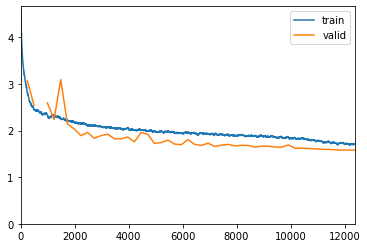

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,2.890132,2.380173,0.341874,0.341874,03:01
1,2.472714,2.769581,0.299925,0.299925,03:01
2,2.343567,2.694196,0.363979,0.363979,03:02
3,2.273574,2.119370,0.430545,0.430545,03:02
4,2.243877,2.040646,0.427782,0.427782,03:02
5,2.180491,2.062419,0.410952,0.410952,03:04
6,2.141709,2.011919,0.441346,0.441346,03:03
7,2.114128,1.853780,0.485808,0.485808,03:02
8,2.122258,1.841762,0.497111,0.497111,03:03
9,2.098896,1.943306,0.464707,0.464707,03:02


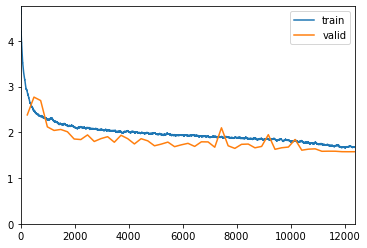

In [28]:
preds_kfold_learns = [get_preds(split_1fold) for split_1fold in splits_kfold[:2]]

In [61]:
(0.598845 + 0.594072)/2

0.5964585

In [29]:
# len(preds_kfold_learns)

In [30]:
# _, learn = preds_kfold_learns[0]

In [31]:
# test_dl = learn.dls.test_dl(test_items)

In [32]:
# preds = learn.get_preds(dl=test_dl)

In [33]:
_before_epoch = [event.before_fit, event.before_epoch]
_after_epoch  = [event.after_epoch, event.after_fit]

In [34]:
@patch
def ttacustom(self:Learner, ds_idx=1, dl=None, n=4, item_tfms=None, batch_tfms=None, beta=0.25, use_max=False):
    "Return predictions on the `ds_idx` dataset or `dl` using Test Time Augmentation"
    if dl is None: dl = self.dls[ds_idx].new(shuffled=False, drop_last=False)
    if item_tfms is not None or batch_tfms is not None: dl = dl.new(after_item=item_tfms, after_batch=batch_tfms)
    try:
        self(_before_epoch)
        with dl.dataset.set_split_idx(0), self.no_mbar():
            if hasattr(self,'progress'): self.progress.mbar = master_bar(list(range(n)))
            aug_preds = []
            for i in self.progress.mbar if hasattr(self,'progress') else range(n):
                self.epoch = i #To keep track of progress on mbar since the progress callback will use self.epoch
                preds = self.get_preds(dl=dl, inner=True)[0][None]
                preds_idx = preds.squeeze().argmax(1)
                aug_preds.append(preds_idx)
#         aug_preds = torch.cat(aug_preds)
#         aug_preds = aug_preds.max(0)[0] if use_max else aug_preds.mean(0)
#         self.epoch = n
#         with dl.dataset.set_split_idx(1): preds,targs = self.get_preds(dl=dl, inner=True)
    finally: self(event.after_fit)

#     if use_max: return torch.stack([preds, aug_preds], 0).max(0)[0],targs
#     preds = (aug_preds,preds) if beta is None else torch.lerp(aug_preds, preds, beta)
    return aug_preds

In [35]:
# aug_preds = learn.ttacustom(dl=test_dl, n=2, beta=None)

In [36]:
# aug_preds

In [37]:
# preds_kfold = [pred_learn[0] for pred_learn in preds_kfold_learns]
learns = [pred_learn[1] for pred_learn in preds_kfold_learns]

In [ ]:
aug_preds = []
for learn in learns:
    test_dl = learn.dls.test_dl(test_items)
    aug_preds_1fold = learn.ttacustom(dl=test_dl, n=100, beta=None)
    aug_preds.extend(aug_preds_1fold)

In [75]:
# preds_kfold = [pred_learn[0][0] for pred_learn in preds_kfold_learns]
# preds_list = [pred.argmax(axis=1) for pred in preds_kfold]
# preds_array = np.array(preds_list)
# final_votes = preds_array[1]

/tmp/ipykernel_1618/2478231715.py:3: FutureWarning: The input object of type 'TensorBase' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'TensorBase', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  preds_array = np.array(preds_list)
/tmp/ipykernel_1618/2478231715.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  preds_array = np.array(preds_list)


In [68]:
preds_array[0]

TensorBase([ 7,  7, 15,  ...,  6,  6, 15])

In [39]:
# aug_preds

In [40]:
len(aug_preds)

62

In [79]:
final_votes = stats.mode(torch.vstack(aug_preds))[0][0]

In [42]:
# preds_kfold = [np.array(preds[0]) for preds in preds_kfold]

In [43]:
# preds_list = [pred.argmax(axis=1) for pred in preds_kfold]

In [44]:
# preds_array = np.array(preds_list)

In [45]:
# preds_array

In [46]:
# values, counts = np.unique(preds_array,axis=0, return_counts=True)

In [47]:
# Counter(preds_array[:,0]).most_common(1)[0][0]

In [48]:
# preds_array.shape

In [49]:
# final_votes = [Counter(preds_array[:,i]).most_common(1)[0][0] for i in range(preds_array.shape[1])]

In [50]:
# final_preds = np.array(preds_kfold).mean(axis=0)

In [51]:
# submission[submission['song_id']=="024013"]

In [80]:
torch.vstack(aug_preds).shape

torch.Size([200, 5076])

In [81]:
final_votes.shape

(5076,)

In [82]:
# preds_idx = final_preds.argmax(axis=1)
genre2id = pd.read_csv('/home/ubuntu/.kaggle/kaggle-pog-series-s01e02/genres.csv')
songid_preds = {int(file_path.stem):genreid_from_genre(learns[0].dls.vocab[_id]) for file_path, _id in zip(test_items,final_votes)}
submission['genre_id'] = submission['song_id'].map(songid_preds)
submission['genre_id'].fillna(0, inplace=True)
submission.loc[submission['song_id']==22612, 'genre_id'] = 1
submission.loc[submission['song_id']==24013, 'genre_id'] = 0

submission.genre_id = submission.genre_id.astype(int)
submission.to_csv(f"submission_final_{int(time.time())}.csv", index=False)

In [83]:
submission

,song_id,genre_id
0,7072,0
1,10207,12
2,20008,0
3,10924,0
4,21896,4
...,...,...
5073,6427,3
5074,16903,0
5075,1731,6
5076,12871,0
